In [65]:
import numpy as np
import random
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

### Load data

In [2]:
ecom_data = pd.read_csv('../data/e_commerce.csv')
ecom_data.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
ecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### Calculate the percentage of users converted

In [7]:
converted_count = ecom_data.query('converted == 1').user_id.nunique()
total_count = ecom_data.shape[0]
print(f'Percentage of users converted: {(converted_count * 100/total_count):.2f}%')

Percentage of users converted: 11.94%


### Calculate the count of inaccuracies

In [8]:
misalign_count = ecom_data.query('(group == "treatment" and landing_page != "new_page" ) \
         or (group != "treatment" and landing_page == "new_page")').count()[0]

print(f'Number of misalignments: {misalign_count}')

Number of misalignments: 3893


In [9]:
ecom_data.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### Remove instances with misalignments

In [11]:
ecom_data_clean = ecom_data.drop(
    ecom_data.query('(group == "treatment" and landing_page != "new_page") or \
                     (group == "control" and landing_page != "old_page")').index
)


In [12]:
ecom_data_clean[((ecom_data_clean['group'] == 'treatment') == (ecom_data_clean['landing_page'] == 'new_page')) == False].shape[0]

0

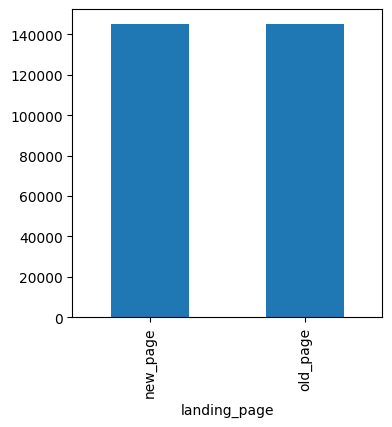

In [ ]:
ecom_data_clean['landing_page'].value_counts().plot(kind='bar', figsize=(4,4))

In [15]:
ecom_data_clean.user_id.duplicated().sum()

1

### Get the duplicated userId

In [16]:
ecom_data_clean[ecom_data_clean.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

In [17]:
ecom_data_clean.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### Drop duplicate

In [19]:
ecom_data_clean.drop(
    index=1899,
    inplace=True
)

In [20]:
ecom_data_clean.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### Calculate probabilities of conversions

In [30]:
prob = ecom_data_clean.query('converted == 1').user_id.nunique() / ecom_data.user_id.nunique()

print(f"Probability of a person converting irrespective of the page: {prob:.4}")

Probability of a person converting irrespective of the page: 0.1196


In [31]:
prob = ecom_data_clean.query('converted == 1 and group == "control"').user_id.nunique() / \
    ecom_data_clean.query('group == "control"').user_id.nunique()

print(f"Probability that the person converted is in the control group: {prob:.4}")

Probability that the person converted is in the control group: 0.1204


In [32]:
prob = ecom_data_clean.query('converted == 1 and group == "treatment"').user_id.nunique() / \
    ecom_data_clean.query('group == "treatment"').user_id.nunique()

print(f"Probability that the person converted is in the treatment group: {prob:.4}")

Probability that the person converted is in the treatment group: 0.1188


In [33]:
prob = ecom_data_clean.query('landing_page == "new_page"').user_id.nunique() / \
    ecom_data_clean.user_id.nunique()

print(f"Probability that a person received the new page: {prob:.4}")

Probability that a person received the new page: 0.5001


- There is not enough evidence to conclude that the new treatment page increases conversions compared to the control page.
- The difference in conversion rates between the control (0.1204) and treatment (0.1188) groups is minimal, especially relative to the overall conversion rate (0.1196).

A/B Testing Approach

- Due to insufficient evidence from initial probability tests, we will resort to conducting an A/B hypothesis test using the entire dataset, considering the timestamps associated with each observation.

- We will base the decision on the full dataset and assume the old page performs better unless the new page shows a statistically significant improvement at a Type I error rate of 5%. The null and alternative hypotheses are as follows:

- Under the null hypothesis, we will assume that the true conversion rates for both the old and new pages are equal, and they match the overall conversion rate observed.

- We will use the same sample sizes for both pages as given in the dataset and perform a sampling distribution analysis for the difference in conversion rates over 10,000 iterations, estimating the conversion difference under the null hypothesis.

Null hypothesis = $H_0:P_{new}-P_{old}\leq0$   
Alt. hypothesis = $H_0:P_{new}-P_{old}>0$  

In [40]:
prob_new = prob_old = ecom_data_clean.converted.mean()
print(f"Under the null hypothesis: \n \
      Prob. for new page converts: {prob_new:.4f} \
        Prob. for old page converts: {prob_old:.4f}")

Under the null hypothesis: 
       Prob. for new page converts: 0.1196         Prob. for old page converts: 0.1196


In [42]:
n_new = ecom_data_clean.query('landing_page == "new_page" ').count()[0]
n_new

145310

In [43]:
n_old = ecom_data_clean.query('landing_page == "old_page" ').count()[0]
n_old

145274

In [47]:
new_page_converted = np.random.choice([0,1],n_new, p=(prob_new, 1-prob_new))
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

In [48]:
old_page_converted = np.random.choice([0,1],n_old, p=(prob_old, 1-prob_old))
old_page_converted

array([1, 1, 1, ..., 1, 0, 1])

In [49]:
diff_converted = new_page_converted.mean() - old_page_converted.mean()
diff_converted

-0.0008443541674036936

In [51]:
new_converted_simulation = np.random.binomial(n_new, prob_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, prob_old,  10000)/n_old
prob_diffs = new_converted_simulation - old_converted_simulation

In [52]:
prob_diffs

array([ 0.00106481, -0.00030485,  0.00275796, ...,  0.00039018,
       -0.00068358,  0.0002939 ])

(array([  15.,  132.,  692., 1890., 2991., 2552., 1294.,  373.,   55.,
           6.]),
 array([-0.00446916, -0.0035324 , -0.00259564, -0.00165887, -0.00072211,
         0.00021465,  0.00115141,  0.00208818,  0.00302494,  0.0039617 ,
         0.00489846]),
 <BarContainer object of 10 artists>)

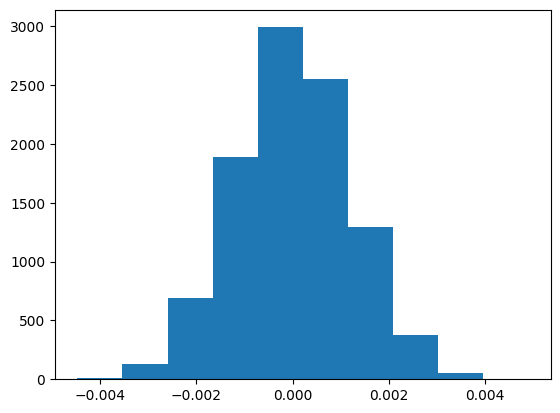

In [53]:
plt.hist(prob_diffs)

In [54]:
new_convert = ecom_data_clean.query('converted == 1 and landing_page == "new_page"').count()[0]/n_new
old_convert = ecom_data_clean.query('converted == 1 and landing_page == "old_page"').count()[0]/n_old
obs_diff = new_convert - old_convert

In [55]:
obs_diff

-0.0015782389853555567

In [56]:
null_vals = np.random.normal(0, prob_diffs.std(), prob_diffs.size)

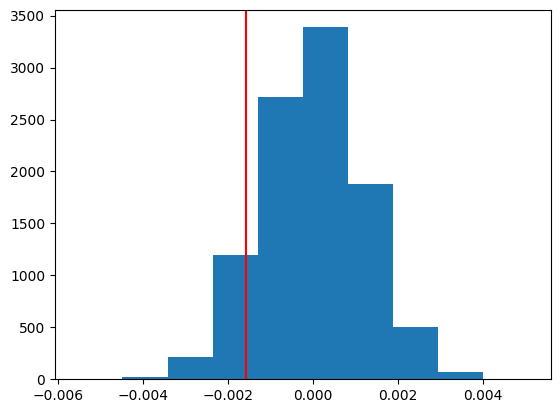

In [57]:
plt.hist(null_vals)
plt.axvline(x=obs_diff, color='red')

In [58]:
(null_vals > obs_diff).mean()

0.9027

- The proportion of simulated conversion differences greater than the observed difference is high. The p-value (90%) far exceeds the Type I error rate (5%), leading us to fail to reject the null hypothesis.

- The p-value, as defined by Wikipedia, is the probability that, under the null hypothesis, the observed statistical result (e.g., the sample mean difference) is as extreme or more extreme than the actual result.

- A low p-value (below 5% in this case) would suggest rejecting the null hypothesis in favor of the alternative. However, the high p-value (90%) here indicates we should stick with the current page.

In [59]:
convert_old = ecom_data_clean.query('converted == 1 and landing_page == "old_page"').count()[0]
convert_new = ecom_data_clean.query('converted == 1 and landing_page == "new_page"').count()[0]
n_old = ecom_data_clean.query('landing_page == "old_page" ').count()[0]
n_new = ecom_data_clean.query('landing_page == "new_page" ').count()[0]

In [60]:
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

In [61]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),\
                                              np.array([n_new,n_old]), alternative = 'larger')

In [62]:
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [63]:
norm.cdf(z_score)

0.09494168724097551

In [64]:
norm.ppf(1-(0.05/2))

1.959963984540054

- Since the z-score of 1.31 is below the critical value of 1.96, we **cannot reject the null hypothesis**. 
- The conversion rate of the old page is at least as high as that of the new page. 
- Additionally, the difference in conversion rates between the old and new pages is **minimal** (less than 0.15%) and not statistically significant.